<h1> Email Classifier </h1> 

In [1]:
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd

In [2]:
#the spam and valid emails are stored in 2 folders called "easy_ham" and "spam"
#we want to read all the files in these 2 folders and pu the filenames into a list of spam and not spam
ham_filenames = [filename for filename in sorted(os.listdir(os.path.join(os.getcwd(),"easy_ham"))) if len(filename) > 20]
spam_filenames = [filename for filename in sorted(os.listdir(os.path.join(os.getcwd(),"spam"))) if len(filename) > 20]

In [3]:
len(ham_filenames)

2551

In [4]:
len(spam_filenames)

500

To parse emails we will use the email library of Python:

How the email library works for parsing:

The parser takes a serialized version of the email message(a stream of bytes) and converts it to a tree of EmailMessage objects.  The generator takes an EmailMessage and turns it back into a serialized byte stream.

There are 2 parser interfaces available, the Parser API and FeedParser API. The Parser API is most useful when you have the entire text of the message in memory or if the entire message lives in a file on the file system. FeedParser API is useful when you are reading the message from a stream which might block your waiting(reading from a url itself)

In [5]:
#collecting all the parsed ham messages
ham_path = os.path.join(os.getcwd(),"easy_ham")
spam_path = os.path.join(os.getcwd(),"spam")

In [6]:
import email
from email import policy


In [7]:
ham_messages = list()
for filename in ham_filenames:
    with open(os.path.join(ham_path,filename),'rb') as f:
        ham_messages.append(email.parser.BytesParser(policy = email.policy.default).parse(f))


In [8]:
spam_messages = list()
for filename in spam_filenames:
    with open(os.path.join(spam_path,filename),'rb') as f:
        spam_messages.append(email.parser.BytesParser(policy = email.policy.default).parse(f))

In [9]:
print(ham_messages[0].get_content().strip())

Date:        Wed, 21 Aug 2002 10:54:46 -0500
    From:        Chris Garrigues <cwg-dated-1030377287.06fa6d@DeepEddy.Com>
    Message-ID:  <1029945287.4797.TMDA@deepeddy.vircio.com>


  | I can't reproduce this error.

For me it is very repeatable... (like every time, without fail).

This is the debug log of the pick happening ...

18:19:03 Pick_It {exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace} {4852-4852 -sequence mercury}
18:19:03 exec pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace 4852-4852 -sequence mercury
18:19:04 Ftoc_PickMsgs {{1 hit}}
18:19:04 Marking 1 hits
18:19:04 tkerror: syntax error in expression "int ...

Note, if I run the pick command by hand ...

delta$ pick +inbox -list -lbrace -lbrace -subject ftp -rbrace -rbrace  4852-4852 -sequence mercury
1 hit

That's where the "1 hit" comes from (obviously).  The version of nmh I'm
using is ...

delta$ pick -version
pick -- nmh-1.0.4 [compiled on fuchsia.cs.mu.OZ.AU at Sun Mar 17 14:55:56 

Emails can have different parts to it, with images, attachments. And these attachments can have emails in them. 

In [10]:
def get_email_structure(email):
    if isinstance(email,str):
        return email
    #get_payload() returns a list if the email is multipart and .is_multipart() = True
    payload = email.get_payload()
    if isinstance(payload,list):
        result = "multipart({})".format(', '.join([get_email_structure(sub_email) for sub_email in payload]))
        return result
    else:
        return email.get_content_type()

In [11]:
from collections import Counter

def structures_counter(emails):
    structures = Counter()
    for email in emails:
        structure = get_email_structure(email)
        structures[structure] += 1
    return structures

In [12]:
structure_counts_ham = structures_counter(ham_messages)
structure_counts_spam = structures_counter(spam_messages)

In [13]:
structure_counts_ham.most_common()

[('text/plain', 2453),
 ('multipart(text/plain, application/pgp-signature)', 72),
 ('multipart(text/plain, text/html)', 8),
 ('multipart(text/plain, text/plain)', 4),
 ('multipart(text/plain)', 3),
 ('multipart(text/plain, application/octet-stream)', 2),
 ('multipart(text/plain, text/enriched)', 1),
 ('multipart(text/plain, application/ms-tnef, text/plain)', 1),
 ('multipart(multipart(text/plain, text/plain, text/plain), application/pgp-signature)',
  1),
 ('multipart(text/plain, video/mng)', 1),
 ('multipart(text/plain, multipart(text/plain))', 1),
 ('multipart(text/plain, application/x-pkcs7-signature)', 1),
 ('multipart(text/plain, multipart(text/plain, text/plain), text/rfc822-headers)',
  1),
 ('multipart(text/plain, multipart(text/plain, text/plain), multipart(multipart(text/plain, application/x-pkcs7-signature)))',
  1),
 ('multipart(text/plain, application/x-java-applet)', 1)]

In [14]:
structure_counts_spam.most_common()

[('text/plain', 221),
 ('text/html', 181),
 ('multipart(text/plain, text/html)', 45),
 ('multipart(text/html)', 19),
 ('multipart(text/plain)', 19),
 ('multipart(multipart(text/html))', 5),
 ('multipart(text/plain, image/jpeg)', 3),
 ('multipart(text/html, application/octet-stream)', 2),
 ('multipart(text/plain, application/octet-stream)', 1),
 ('multipart(text/html, text/plain)', 1),
 ('multipart(multipart(text/html), application/octet-stream, image/jpeg)', 1),
 ('multipart(multipart(text/plain, text/html), image/gif)', 1),
 ('multipart/alternative', 1)]

In [15]:
type_list = list()
temp = [[type_list.append(i) for i in structures] for structures in [structure_counts_ham, structure_counts_spam]]
ham_type_counts = [structure_counts_ham[i] for i in set(type_list)]
spam_type_counts = [structure_counts_spam[i] for i in set(type_list)]

In [16]:
type_counts_df = pd.DataFrame({'Email Type':list(set(type_list)), 'Ham Count':ham_type_counts, 'Spam Count':spam_type_counts})
type_counts_df

,Email Type,Ham Count,Spam Count
0,"multipart(text/plain, application/octet-stream)",2,1
1,"multipart(text/html, application/octet-stream)",0,2
2,"multipart(text/plain, multipart(text/plain))",1,0
3,"multipart(text/plain, multipart(text/plain, te...",1,0
4,"multipart(text/plain, application/x-pkcs7-sign...",1,0
5,"multipart(text/plain, text/html)",8,45
6,"multipart(multipart(text/plain, text/plain, te...",1,0
7,text/plain,2453,221
8,"multipart(text/plain, application/pgp-signature)",72,0
9,multipart(text/plain),3,19


Most valid(ham) emails are text/plain and contain a PGP(Pretty Good Privacy) signature, while Spam emails have a higher amount of HTML messages. 

In [17]:
#create a list of type of each email 
ham_email_type = [get_email_structure(email) for email in ham_messages]
spam_email_type = [get_email_structure(email) for email in spam_messages]

In [18]:
def FindEmailSender(email):
    try:
        return dict(email.items())['From']
    except:
        return "N/A"

In [19]:
#creating list of senders of each email
ham_email_senders = [FindEmailSender(email) for email in ham_messages]
spam_email_senders = [FindEmailSender(email) for email in spam_messages]

In [20]:
#combining the dataset to create a complete dataset for splitting into train and test sets
import numpy as np
X = np.array(ham_messages + spam_messages, dtype = object)
y = np.array([0] * len(ham_messages) + [1]*len(spam_messages))

In [21]:
from sklearn.model_selection import train_test_split

X_train,X_test,y_train,y_test = train_test_split(X,y,random_state=42, test_size=0.2)

In [22]:
#turning html in emails into tags we want
#turn head tags into ''
#turn anchor tags into hyper links
#turn all html tags into ''
import re
from html import unescape
def html_to_text(html):
    text = re.sub(r'<head.*?>.*?</head>','',html,flags = re.I|re.M|re.S)
    text = re.sub(r'<a.*?>.*?</a>',' HYPERLINK ',text,flags = re.I|re.M|re.S)
    text = re.sub(r'<.*?>','',text,flags=re.M|re.I|re.S)
    text = re.sub(r'(\s*\n)+','\n',text,flags = re.M|re.I|re.S)
    return unescape(text)

In [23]:
idx_html = [i for i in range(len(X_train)) if get_email_structure(X_train[i]) == 'text/html']

In [24]:
html_to_text(X_train[idx_html[5]].get_content().strip())

'\n HYPERLINK\nCopyright 2002 - All rights reservedIf you would no longer like us\nto contact you or feel that you havereceived this email in error,\nplease  HYPERLINK .'

In [25]:
#check if any EmailMessage objects have more tha one text/html type occuring
html_check = list()
for j in range(len(X_train)):
    i = 0
    for part in X_train[j].walk():
        if part.get_content_type() == 'text/plain':
            i += 1
        if i == 2:
            html_check.append(j)
    
html_check

[41, 805, 942, 1131, 1219, 2033, 2134, 2266]

In [26]:
def email_to_text(email):
    html = None
    for sub_email in email.walk():
        content_type = sub_email.get_content_type()
        if content_type not in ('text/html','text/plain'):
            continue
        try:
            content = sub_email.get_content()
        except:
            content = str(sub_email.get_payload())
        if content_type == 'text/plain':
            return content
        else:
            html = content
    if html:
        return html_to_text(html)

In [27]:
def email_to_text_multipart(email,f,i):
    html = None
    #the first sub_email that is traversed is the main parent email itself. the following will be the children
    for sub_email in email.walk():
        content_type = sub_email.get_content_type()
        f.write('{},{}\n'.format(i,content_type))
        if content_type not in ('text/html','text/plain'):
            #if the parent mail is multipart, use this route
            content_type = email.get_content_type()
            if re.fullmatch(r'multipart/[a-zA-Z]+',content_type) != None:
                textlist = list()
                for sub_email_1 in email.get_payload():
                    try:
                        if sub_email_1.get_content_type() == 'text/plain':
                            textlist.append(sub_email_1.get_content())
                        elif sub_email_1.get_content_type() == 'text/html':
                            textlist.append(html_to_text(sub_email_1.get_content()))
                        else:
                            continue
                    except:
                        if(isinstance(sub_email_1,str)):
                            textlist.append(sub_email_1)
                        else:
                            continue
                if (len(textlist) > 0):
                    return ' '.join(textlist)
            else:
                continue
        try:
            content = sub_email.get_content()
        except:
            content = str(sub_email.get_payload())
        if content_type == 'text/plain':
            return content
        else:
            f.write('{},{}\n'.format(i,content_type))
            html = content
    if html:
        try:
            return html_to_text(html)
        except:
            f.write('{},{}\n'.format(i,html))
            f.close()
            return TypeError

In [28]:
def email_to_text_multipart_2(email,f,i):
    html = None
    email_type = email.get_content_type()
    #j is used as a counter to count on the walk attribute
    textlist = list()
    j = 0
    for sub_email in email.walk():
        j += 1
        sub_type = sub_email.get_content_type()
        f.write('{},{}\n'.format(i,sub_type))
        if sub_type not in ('text/plain','text/html'):
            #if the parent is not text/plain or text/html we want to continue
            continue
        #this is to get the content if the parent is text/html or text/plain
        elif ((j==1) & (sub_type in ('text/plain','text/html')) & (re.fullmatch(r'multipart/[a-zA-Z]+',email_type) == None)):
            try:
                content = sub_email.get_content()
            except:
                content = str(sub_email.get_payload())
            if (sub_type == 'text/plain'):
                f.write('{},2nd Condition,{},{}\n'.format(i,email_type,sub_type))
                return content
            else:
                html = content
                return html_to_text(html)
        elif ((j!=1) & (re.fullmatch(r'multipart/[a-zA-Z]+',email_type) != None)):
            f.write('{},MULTIPART,{}\n'.format(i,sub_type))
            try:
                if sub_type == 'text/plain':
                    f.write('{},wrote to textlist,{},{},j:{}\n'.format(i,sub_type,len(textlist),j))
                    textlist.append(sub_email.get_content())
                elif sub_type == 'text/html':
                    f.write('{},wrote to textlist,{},{},j:{}\n'.format(i,sub_type,len(textlist),j))
                    textlist.append(html_to_text(sub_email.get_content()))
                elif(sub_type not in ('text/plain','text/html')):
                    f.write('Not text/html or text/plain \n')
                    continue
            except:
                if(isinstance(sub_email,str)):
                    f.write('{},wrote to textlist as string,{},{}\n'.format(i,sub_type,len(textlist)))
                    textlist.append(sub_email)
                else:
                    continue
    if (len(textlist) > 0):
        return ' '.join(textlist)








In [29]:
#converts emails in the body to "EMAIL"
import re
def convert_email_tags(email_text):
    return re.sub(r'([a-zA-Z0-9\._-]+@[a-zA-Z0-9\._-]+\.[a-zA-Z0-9\._-]+)',' EMAIL-LINK ',email_text,flags = re.I|re.S|re.M)

In [30]:
#remove stopwords
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

def remove_stopwords(email_text):
    stop_words = set(stopwords.words("english"))
    words = word_tokenize(email_text.strip())
    return [i for i in words if i not in stop_words]

In [31]:
#stem the words to get the root of words
from nltk.stem import PorterStemmer

def stemmer(email_word_list):
    ps = PorterStemmer()
    return [ps.stem(w) for w in email_word_list]

In [32]:
from sklearn.base import BaseEstimator,TransformerMixin
import urlextract
import re
class EmailToWord(BaseEstimator,TransformerMixin):
    def __init__(self,lower_case = True, remove_email = True, remove_punctuation = True, remove_urls = True, stemming = True, remove_stopwords = True, remove_numbers = True):
         self.lower_case =lower_case
         self.remove_email = remove_email
         self.remove_punctuation = remove_punctuation
         self.remove_urls = remove_urls
         self.stemming = stemming
         self.remove_stopwords = remove_stopwords
         self.remove_numbers = remove_numbers
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        X_transformed = []
        with open('log.txt','w') as f:
            for i,email in enumerate(X):
                text = email_to_text_multipart_2(email,f,i) or ""
                if self.lower_case:
                    text = text.lower()
                if self.remove_urls:
                    url_extractor = urlextract.URLExtract()
                    urls = url_extractor.find_urls(text)
                    for url in urls:
                        text = text.replace(url,' URL ')
                if self.remove_punctuation:
                    text = re.sub(r'[^a-zA-Z0-9_]',' ', text, flags = re.M|re.S|re.I)
                if self.remove_numbers:
                    text = re.sub(r'\d+(?:\.\d*)?(?:[eE][+-]?\d+)?', ' NUMBER ', text, flags = re.I|re.S|re.M)
                if self.remove_email:
                    text = convert_email_tags(text)
                if self.remove_stopwords:
                    #words without stemming
                    word_list = remove_stopwords(text)
                if self.stemming:
                    stemmed_list = stemmer(word_list)
                X_transformed.append(stemmed_list)
        return X_transformed
    

In [33]:
from sklearn.base import BaseEstimator,TransformerMixin
import urlextract
import re
from collections import Counter
class CountWords(BaseEstimator,TransformerMixin):
    def __init__(self):
        return None
    def fit(self,X,y = None):
        return self
    def transform(self,X,y = None):
        #create a word vector
        X_wordcounts = []
        for email_word_list in X:
            X_wordcounts.append(Counter(email_word_list))
        #returns a Counter object
        return X_wordcounts

In [34]:
from sklearn.base import BaseEstimator,TransformerMixin
from scipy.sparse import csr_matrix
import numpy as np
class CreateWordVector(BaseEstimator, TransformerMixin):
    def __init__(self,vocabulary_size = 1000):
        self.vocabulary_size = vocabulary_size
    def fit(self,X,y=None):
        total_count = Counter()
        for email in X:
            #each email is a counter object here
            for word,count in email.items():
                total_count[word] += min(count,10)
        self.most_common = total_count.most_common()[:self.vocabulary_size]
        self.vocabulary_ = {word:index + 1 for index,(word,count) in enumerate(self.most_common)}
        return self
    def transform(self,X,y=None):
        rows = []
        cols = []
        occurences = []
        result_array = np.zeros(shape = (len(X),self.vocabulary_size + 1))
        for i,email in enumerate(X):
            for word,count in email.items():
                #getting the index position for the word in most common dictionary. This will be used as the entry to cols
                idx = self.vocabulary_.get(word,0)
                if idx == 0:
                    result_array[i,0] = result_array[i,0] + count
                else:
                    result_array[i,idx] = result_array[i,idx] + count  
        return [result_array,self.most_common]

In [35]:
from sklearn.pipeline import Pipeline

datatransformation = Pipeline([
    ('emailtoword',EmailToWord()),
    ('countwords',CountWords()),
    ('createwordvector',CreateWordVector())
])

In [36]:
res = datatransformation.fit_transform(X_train)

In [37]:
X_train_transformed = res[0]
most_common = res[1]

In [38]:
len(most_common)

1000

In [39]:
#making a dataframe from the data we have obtained of the transformed emails
import pandas as pd
columns = [i[0] for i in most_common]
columns.insert(0,'Not in Vocabulary')
X_train_transformed_df = pd.DataFrame(data = X_train_transformed,columns = columns)

In [40]:
X_train_transformed_df['Result'] = y_train
X_train_transformed_df

,Not in Vocabulary,number,url,list,use,mail,get,one,time,like,...,owner,decis,expert,match,btw,middl,mode,effici,startup,Result
0,11.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
1,18.0,10.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2,22.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1
3,77.0,22.0,0.0,0.0,3.0,2.0,3.0,0.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,19.0,17.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,14.0,6.0,4.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2436,43.0,11.0,1.0,1.0,3.0,1.0,1.0,3.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0
2437,9.0,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
2438,16.0,11.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [41]:
#drawing histogram for spam email and normal email to see word distributions. 
#words not in vocabulary will be left out and we shall only draw for the most occuring 20 words in each category
df_ham = X_train_transformed_df.loc[X_train_transformed_df["Result"] == 0]
df_ham = df_ham.drop(["Not in Vocabulary", "Result"],1)
df_ham

,number,url,list,use,mail,get,one,time,like,com,...,approv,owner,decis,expert,match,btw,middl,mode,effici,startup
0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,10.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,0.0,3.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,22.0,0.0,0.0,3.0,2.0,3.0,0.0,0.0,4.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,17.0,5.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,8.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2435,6.0,4.0,2.0,1.0,2.0,1.0,1.0,1.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2436,11.0,1.0,1.0,3.0,1.0,1.0,3.0,0.0,1.0,2.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2437,1.0,2.0,3.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2438,11.0,1.0,3.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [42]:
df_spam = X_train_transformed_df.loc[X_train_transformed_df["Result"] == 1]
df_spam = df_spam.drop(["Not in Vocabulary", "Result"],1)
df_spam

,number,url,list,use,mail,get,one,time,like,com,...,approv,owner,decis,expert,match,btw,middl,mode,effici,startup
2,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5,21.0,4.0,1.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
15,2.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
24,4.0,5.0,2.0,2.0,8.0,2.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
28,10.0,4.0,1.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2407,5.0,0.0,1.0,0.0,2.0,0.0,0.0,2.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2409,241.0,2.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2412,5.0,0.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2422,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


In [43]:
ham_words_means = df_ham.mean(axis = 0)
ham_words_means

number     12.582801
url         2.417690
list        1.002948
use         0.812776
mail        0.569533
             ...    
btw         0.029484
middl       0.027027
mode        0.027027
effici      0.030958
startup     0.016216
Length: 1000, dtype: float64

In [44]:
spam_words_means = df_spam.mean(axis = 0)
spam_words_means

number     18.572840
url         1.748148
list        1.029630
use         0.530864
mail        1.839506
             ...    
btw         0.000000
middl       0.012346
mode        0.012346
effici      0.004938
startup     0.086420
Length: 1000, dtype: float64

In both spam and normal messages, numbers and urls tend to be majority of the occurences in total. Hence we shall avoid these to see a more clearer piture of the highly occuring words

In [45]:
sorted_ham_word_means = sorted(ham_words_means.tolist(), reverse = True)[2:25]

In [46]:
sorted_ham_word_labels= ham_words_means.index.values.tolist()[2:25]

In [47]:
sorted_spam_word_means = sorted(spam_words_means.tolist(), reverse = True)[2:25]

In [48]:
sorted_spam_word_labels= spam_words_means.index.values.tolist()[2:25]

[Text(0, 0, 'list'),
 Text(1, 0, 'use'),
 Text(2, 0, 'mail'),
 Text(3, 0, 'get'),
 Text(4, 0, 'one'),
 Text(5, 0, 'time'),
 Text(6, 0, 'like'),
 Text(7, 0, 'com'),
 Text(8, 0, 'messag'),
 Text(9, 0, 'would'),
 Text(10, 0, 'email'),
 Text(11, 0, 'work'),
 Text(12, 0, 'new'),
 Text(13, 0, 'make'),
 Text(14, 0, 'peopl'),
 Text(15, 0, 'rpm'),
 Text(16, 0, 'user'),
 Text(17, 0, 'net'),
 Text(18, 0, 'free'),
 Text(19, 0, 'date'),
 Text(20, 0, 'wrote'),
 Text(21, 0, 'go'),
 Text(22, 0, 'want')]

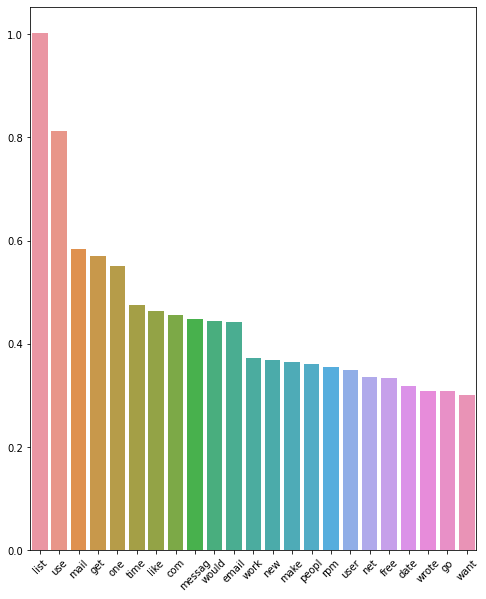

In [49]:
import matplotlib.pyplot as plt
import seaborn as sns
fig,ax_ham_words = plt.subplots(1,1,figsize = (8,10))
sns.barplot(x = sorted_ham_word_labels, y = sorted_ham_word_means, ax = ax_ham_words)
ax_ham_words.set_xticklabels(ax_ham_words.get_xticklabels(), rotation = 45)

[Text(0, 0, 'list'),
 Text(1, 0, 'use'),
 Text(2, 0, 'mail'),
 Text(3, 0, 'get'),
 Text(4, 0, 'one'),
 Text(5, 0, 'time'),
 Text(6, 0, 'like'),
 Text(7, 0, 'com'),
 Text(8, 0, 'messag'),
 Text(9, 0, 'would'),
 Text(10, 0, 'email'),
 Text(11, 0, 'work'),
 Text(12, 0, 'new'),
 Text(13, 0, 'make'),
 Text(14, 0, 'peopl'),
 Text(15, 0, 'rpm'),
 Text(16, 0, 'user'),
 Text(17, 0, 'net'),
 Text(18, 0, 'free'),
 Text(19, 0, 'date'),
 Text(20, 0, 'wrote'),
 Text(21, 0, 'go'),
 Text(22, 0, 'want')]

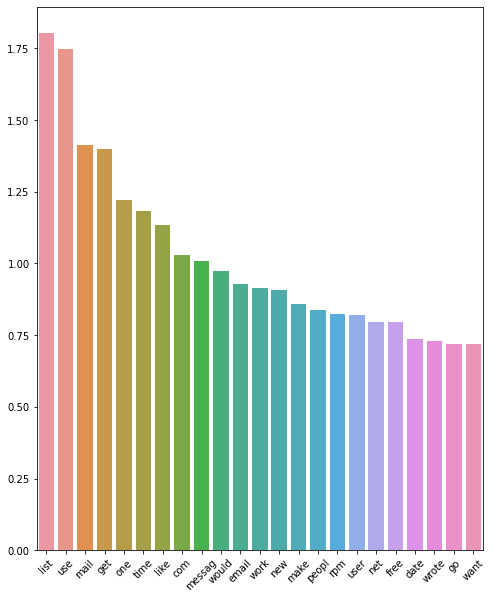

In [50]:
fig,ax_spam_words = plt.subplots(1,1,figsize = (8,10))
sns.barplot(x = sorted_spam_word_labels, y = sorted_spam_word_means, ax = ax_spam_words) 
ax_spam_words.set_xticklabels(ax_spam_words.get_xticklabels(), rotation = 45)

In [51]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import StratifiedKFold

<h3> Using Logistic Regression Model </h3> 

In [52]:
skf = StratifiedKFold(n_splits=3)
log_reg = LogisticRegression(solver="lbfgs", max_iter = 1000, random_state = 42)

In [53]:
columns = X_train_transformed_df.columns.tolist()[:-1]

In [54]:
log_reg.fit(X_train_transformed_df[columns],X_train_transformed_df["Result"])

LogisticRegression(max_iter=1000, random_state=42)

In [72]:
from sklearn.metrics import confusion_matrix
confusion_matrix(X_train_transformed_df["Result"],log_reg.predict(X_train_transformed_df[columns]))

array([[2035,    0],
       [   5,  400]], dtype=int64)

In [56]:
from sklearn.model_selection import cross_val_predict
log_reg_cross_val = LogisticRegression(solver="lbfgs", max_iter = 1000, random_state = 42)
y_pred = cross_val_predict(log_reg_cross_val,X_train_transformed_df[columns],X_train_transformed_df["Result"], cv = skf,verbose = 3)
conf_matrix_log_reg = confusion_matrix(X_train_transformed_df["Result"], y_pred)
conf_matrix_log_reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.9s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    2.3s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    3.5s finished


array([[2031,    4],
       [  29,  376]], dtype=int64)

In [58]:
conf_matrix_log_reg[0,0]/np.sum(conf_matrix_log_reg,axis = 0)[0]

0.9859223300970874

In [59]:
df_spam.shape

(405, 1000)

In [60]:
from sklearn.metrics import precision_score
precision_score(X_train_transformed_df["Result"], y_pred)

0.9894736842105263

In [61]:
from sklearn.metrics import recall_score
recall_score(X_train_transformed_df["Result"], y_pred)

0.928395061728395

In [62]:
from sklearn.metrics import f1_score
f1_score(X_train_transformed_df["Result"], y_pred)

0.9579617834394905

<h3> Support Vector Classifier </h3> 

In [67]:
from sklearn.svm import SVC


In [71]:
svm_clf = SVC(kernel = 'rbf',gamma = 'scale')
svm_clf.fit(X_train_transformed_df[columns],X_train_transformed_df["Result"])
confusion_matrix(X_train_transformed_df["Result"],svm_clf.predict(X_train_transformed_df[columns]))

array([[2035,    0],
       [ 290,  115]], dtype=int64)

In [69]:
svm_clf_cross_val = SVC(kernel = 'rbf',gamma = 'scale')
y_pred_svm = cross_val_predict(svm_clf_cross_val,X_train_transformed_df[columns],X_train_transformed_df["Result"], cv = skf,verbose = 3)
conf_matrix_svm_clf = confusion_matrix(X_train_transformed_df["Result"], y_pred_svm)
conf_matrix_svm_clf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    1.7s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    3.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    4.3s finished


array([[2033,    2],
       [ 360,   45]], dtype=int64)

In [73]:
print("Precision of SVM: {}".format(precision_score(X_train_transformed_df["Result"], y_pred_svm)))
print("Recall of SVM: {}".format(recall_score(X_train_transformed_df["Result"], y_pred_svm)))

Precision of SVM: 0.9574468085106383
Recall of SVM: 0.1111111111111111


<h3> Random Forest Classifier </h3>

In [74]:
from sklearn.ensemble import RandomForestClassifier


In [76]:
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs = -1, random_state=42)
rnd_clf.fit(X_train_transformed_df[columns],X_train_transformed_df["Result"])
confusion_matrix(X_train_transformed_df["Result"],rnd_clf.predict(X_train_transformed_df[columns]))

array([[2035,    0],
       [ 148,  257]], dtype=int64)

In [77]:
rnd_clf_cross_val = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs = -1, random_state=42)
y_pred_rnd = cross_val_predict(rnd_clf_cross_val,X_train_transformed_df[columns],X_train_transformed_df["Result"], cv = skf,verbose = 3)
conf_matrix_rnd_clf = confusion_matrix(X_train_transformed_df["Result"], y_pred_rnd)
conf_matrix_rnd_clf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    6.6s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    8.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:    9.3s finished


array([[2031,    4],
       [ 173,  232]], dtype=int64)

<h3> AdaBoost Classifier </h3> 

In [80]:
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier

In [81]:
ada_clf = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 200, algorithm = "SAMME.R", learning_rate = 0.5)
ada_clf.fit(X_train_transformed_df[columns],X_train_transformed_df["Result"])
confusion_matrix(X_train_transformed_df["Result"],ada_clf.predict(X_train_transformed_df[columns]))

array([[2035,    0],
       [   0,  405]], dtype=int64)

In [82]:
ada_clf_cross_val = AdaBoostClassifier(DecisionTreeClassifier(max_depth=1), n_estimators = 200, algorithm = "SAMME.R", learning_rate = 0.5)
y_pred_ada = cross_val_predict(ada_clf_cross_val,X_train_transformed_df[columns],X_train_transformed_df["Result"], cv = skf,verbose = 3)
conf_matrix_ada_clf = confusion_matrix(X_train_transformed_df["Result"], y_pred_ada)
conf_matrix_ada_clf

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    9.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   18.5s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   27.6s finished


array([[2023,   12],
       [  26,  379]], dtype=int64)

In [83]:
print("Precision of Adaboost: {}".format(precision_score(X_train_transformed_df["Result"], y_pred_ada)))
print("Recall of Adaboost: {}".format(recall_score(X_train_transformed_df["Result"], y_pred_ada)))

Precision of Adaboost: 0.969309462915601
Recall of Adaboost: 0.9358024691358025


In [85]:
ada_clf_log_reg = AdaBoostClassifier(base_estimator=LogisticRegression(solver="lbfgs", max_iter = 1000, random_state = 42), n_estimators = 200, algorithm = "SAMME.R", learning_rate = 0.5)
y_pred_ada_log_reg = cross_val_predict(ada_clf_log_reg,X_train_transformed_df[columns],X_train_transformed_df["Result"], cv = skf,verbose = 3)
conf_matrix_ada_log_reg = confusion_matrix(X_train_transformed_df["Result"], y_pred_ada_log_reg)
conf_matrix_ada_log_reg

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   18.0s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   37.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   3 out of   3 | elapsed:   58.4s finished


array([[2027,    8],
       [  27,  378]], dtype=int64)

<h3> Using AdaBoost with the Logistic Regression algorithm as the base algorithm </h3> 

Given that out of all the above estimators, Logistic Regression and Adaptive Gradient Boosting works the best, for the next step, we can use Adaptive Gradient Boosting with Logistic Regression as its base estimator.

In [86]:
print("Precision of Adaboost with LogReg: {}".format(precision_score(X_train_transformed_df["Result"], y_pred_ada_log_reg)))
print("Recall of Adaboost with LogReg: {}".format(recall_score(X_train_transformed_df["Result"], y_pred_ada_log_reg)))

Precision of Adaboost with LogReg: 0.9792746113989638
Recall of Adaboost with LogReg: 0.9333333333333333


There is a slight improvement in Precision, however the Recall has decreased by a negligible amount. 

<h3> Hyper parameter tuning of Logistic Regression and AdaBoost </h3> 

In [153]:
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import make_scorer
from sklearn.metrics import f1_score
parameters_log_reg = {
    'C':(0.1,0.5,1.0,10),
    'max_iter':(100,1000)
}

parameters_log_reg2 =  {
    'solver' : ('liblinear','saga','lbfgs')}

scoring_log_reg = {"Precision" : make_scorer(precision_score), "Recall":make_scorer(recall_score), "F1Score":make_scorer(f1_score)}

grid_log_reg = GridSearchCV(estimator = LogisticRegression(solver="lbfgs", random_state = 42), param_grid = parameters_log_reg, 
scoring = scoring_log_reg, refit = "F1Score",verbose = 2, return_train_score = True)

grid_log_reg.fit(X_train_transformed_df[columns],X_train_transformed_df["Result"])

Fitting 5 folds for each of 8 candidates, totalling 40 fits
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[CV] END ................................C=0.1, max_iter=100; total time=   0.4s
C:\Users\ASUS\AppData\Local\Programs\Python\Python38\lib\site-packages\sklearn\linear_model\_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org

GridSearchCV(estimator=LogisticRegression(random_state=42),
             param_grid={'C': (0.1, 0.5, 1.0, 10), 'max_iter': (100, 1000)},
             refit='F1Score', return_train_score=True,
             scoring={'F1Score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)},
             verbose=2)

In [154]:
grid_log_reg.best_score_

0.9591079880776748

In [164]:
log_reg_optimized = grid_log_reg.best_estimator_
log_reg_optimized

LogisticRegression(C=0.5, random_state=42)

In [156]:
precision_score(X_train_transformed_df["Result"],log_reg_optimized.predict(X_train_transformed_df[columns]))

1.0

In [157]:
recall_score(X_train_transformed_df["Result"],log_reg_optimized.predict(X_train_transformed_df[columns]))

0.9827160493827161

After Hyperparameter tuning of the logistic regression estimator, we obtain very high precision and high recall. Note: this is not expected to have the same precision and recall as grid_search_cv results as the results of grid_search_cv is an average off all the splits used in cross validation. 

In [158]:
param_combo = list(zip(*(grid_log_reg.cv_results_["param_max_iter"].data,grid_log_reg.cv_results_["param_C"].data)))
param_combo

[(100, 0.1),
 (1000, 0.1),
 (100, 0.5),
 (1000, 0.5),
 (100, 1.0),
 (1000, 1.0),
 (100, 10),
 (1000, 10)]

In [145]:
params_set = grid_log_reg.cv_results_["params"]
[[idx for idx in range(len(params_set)) if ((params_set[idx]['C'] == param_combo[i][1]) & (params_set[idx]['max_iter'] == param_combo[i][0]))] for i in range(len(param_combo))]

[[0], [1], [2], [3], [4], [5], [6], [7]]

In [138]:
grid_log_reg.cv_results_["params"]

[{'C': 0.1, 'max_iter': 100},
 {'C': 0.1, 'max_iter': 1000},
 {'C': 1.0, 'max_iter': 100},
 {'C': 0.5, 'max_iter': 1000},
 {'C': 1.0, 'max_iter': 100},
 {'C': 1.0, 'max_iter': 1000},
 {'C': 10, 'max_iter': 100},
 {'C': 10, 'max_iter': 1000}]

In [147]:
grid_log_reg.cv_results_.keys()

dict_keys(['mean_fit_time', 'std_fit_time', 'mean_score_time', 'std_score_time', 'param_C', 'param_max_iter', 'params', 'split0_test_Precision', 'split1_test_Precision', 'split2_test_Precision', 'split3_test_Precision', 'split4_test_Precision', 'mean_test_Precision', 'std_test_Precision', 'rank_test_Precision', 'split0_test_Recall', 'split1_test_Recall', 'split2_test_Recall', 'split3_test_Recall', 'split4_test_Recall', 'mean_test_Recall', 'std_test_Recall', 'rank_test_Recall', 'split0_test_F1Score', 'split1_test_F1Score', 'split2_test_F1Score', 'split3_test_F1Score', 'split4_test_F1Score', 'mean_test_F1Score', 'std_test_F1Score', 'rank_test_F1Score'])

In [146]:
list(zip(*(scoring_log_reg, ["b",'r','g'])))

[('Precision', 'b'), ('Recall', 'r'), ('F1Score', 'g')]

In [151]:
x_label_list = ['C : ' + str(params_set[idx]['C']) + ' max_iter:' + str(params_set[idx]['max_iter']) for idx in range(len(params_set))]
x_label_list

['C : 0.1 max_iter:100',
 'C : 0.1 max_iter:1000',
 'C : 0.5 max_iter:100',
 'C : 0.5 max_iter:1000',
 'C : 1.0 max_iter:100',
 'C : 1.0 max_iter:1000',
 'C : 10 max_iter:100',
 'C : 10 max_iter:1000']

<ipython-input-163-f3dcfc9c4e89>:7: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax_log_reg_grid.set_xticklabels(x_label_list, rotation = 45)


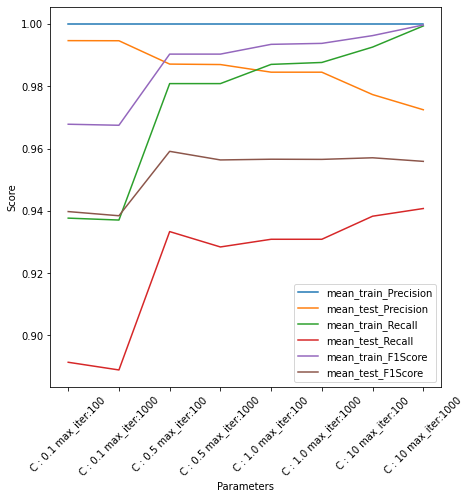

In [163]:
mean_precision = list()
mean_recall = list()
mean_f1score = list()
fig,ax_log_reg_grid = plt.subplots(1,1,figsize = (7,7))
ax_log_reg_grid.set_xlabel('Parameters')
ax_log_reg_grid.set_ylabel('Score')
ax_log_reg_grid.set_xticklabels(x_label_list, rotation = 45)
for score_type,color in list(zip(*(scoring_log_reg, ["b",'r','g']))):
    for (sample_type,style) in (('train','--'),('test','-')):
        sample_mean_score = grid_log_reg.cv_results_['mean_{}_{}'.format(sample_type,score_type)]
        ax_log_reg_grid.plot(x_label_list,sample_mean_score, label = 'mean_{}_{}'.format(sample_type,score_type))
    
ax_log_reg_grid.legend()

The best parameters which give a good F1 Score are C:0.5 and max_iter:100. We shall use this logistic regression mode as the base estimator in an AdaBoost Classifier

In [165]:
grid_log_reg.best_params_

{'C': 0.5, 'max_iter': 100}

In [168]:
parameters_ada_boost = {
    'n_estimators' : (100,150,200,300),
    'learning_rate' : (0.5,0.75,1)
}

scoring_ada_boost = {"Precision" : make_scorer(precision_score), "Recall":make_scorer(recall_score), "F1Score":make_scorer(f1_score)}


estimator_ada_boost = AdaBoostClassifier(base_estimator=LogisticRegression(solver="lbfgs", C = 0.5, max_iter = 100, random_state = 42), algorithm='SAMME.R',random_state=42)


grid_ada_boost = GridSearchCV(estimator = estimator_ada_boost, param_grid = parameters_ada_boost, scoring = scoring_ada_boost, refit = "F1Score",verbose = 2, return_train_score = True)

grid_ada_boost.fit(X_train_transformed_df[columns],X_train_transformed_df["Result"])

Fitting 5 folds for each of 12 candidates, totalling 60 fits
[CV] END ................learning_rate=0.5, n_estimators=100; total time=  12.3s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=  11.2s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=  11.4s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=  10.4s
[CV] END ................learning_rate=0.5, n_estimators=100; total time=   8.3s
[CV] END ................learning_rate=0.5, n_estimators=150; total time=  17.0s
[CV] END ................learning_rate=0.5, n_estimators=150; total time=  16.9s
[CV] END ................learning_rate=0.5, n_estimators=150; total time=  16.3s
[CV] END ................learning_rate=0.5, n_estimators=150; total time=  14.1s
[CV] END ................learning_rate=0.5, n_estimators=150; total time=  11.0s
[CV] END ................learning_rate=0.5, n_estimators=200; total time=  21.2s
[CV] END ................learning_rate=0.5, n_es

GridSearchCV(estimator=AdaBoostClassifier(base_estimator=LogisticRegression(C=0.5,
                                                                            random_state=42),
                                          random_state=42),
             param_grid={'learning_rate': (0.5, 0.75, 1),
                         'n_estimators': (100, 150, 200, 300)},
             refit='F1Score', return_train_score=True,
             scoring={'F1Score': make_scorer(f1_score),
                      'Precision': make_scorer(precision_score),
                      'Recall': make_scorer(recall_score)},
             verbose=2)